# **PRÀCTICA 1: Identificació d'idioma**

# Main program

## Setup

In [25]:
import math
import nltk
from nltk.collocations import TrigramCollocationFinder
import json
import os
from typing import Callable

In [76]:
# Load trigrams and unique characters from json files
def dict_string_to_trigramtuple(d: dict) -> dict:
    return {key: {tuple(k): v for k, v in value.items()} for key, value in d.items()}

def refactor_validation(d: dict) -> dict:
    return {key: {k: ({tuple(k2): v2 for k2, v2 in v[0].items()}, v[1]) for k, v in value.items()} for key, value in d.items()}

trigrams = dict_string_to_trigramtuple(json.load(open('./weights/trigrams.json')))
unique_chars = json.load(open('./weights/unique_chars.json'))

# Load preprocessed data (train and test)
train = json.load(open('./preprocessed_langId/train.json'))
test = json.load(open('./preprocessed_langId/test.json'))

validation_trigrams = refactor_validation(json.load(open('./weights/validation_trigrams.json')))
validation_unique = json.load(open('./weights/validation_unique_chars.json'))


In [77]:
# Dictionaries to optimize Lidstone smoothing calculation
b_dict = {key: value ** 3 for key, value in unique_chars.items()}
totals = {key: sum(trigrams[key].values()) for key in trigrams.keys()}

# Functions for Lidstone smoothing
def lidstone_smooth(language: str, trigram: tuple, lambda_value: float = 0.5, b_values: dict = b_dict, model: dict = trigrams):
    counts = model[language]
    vocab = b_values[language]
    total = sum(model[language].values())
    number = counts.get(trigram, 0)
    probs = (number + lambda_value) / (total + lambda_value * vocab)
    return probs

def pau_discounting(language: str, trigram: tuple, delta: float = 0.1, b_values:dict = b_dict, model: dict = trigrams):
    counts = model[language]
    total = sum(model[language].values())
    number = counts.get(trigram, 0)
    unique = len(counts)
    prob = max(number - delta, 0) / total + (delta * unique / total) * (1 / unique)
    return prob

def absolute_discounting(language: str, trigram: tuple, alpha: float = 0.1, b_values: dict = b_dict, model: dict = trigrams):
    counts = model[language]
    total = sum(model[language].values())
    vocab = b_values[language]
    count_trigram = counts.get(trigram, 0)
    unique = len(counts)
    if count_trigram == 0:
        prob = ((vocab - unique)*alpha/unique)/total
    else:
        prob = ((count_trigram - alpha)/ total)
    return prob

def linear_discounting(language: str, trigram: tuple, alpha: float = 0.1, b_values: dict = b_dict, model: dict = trigrams):
    counts = model[language]
    total = sum(model[language].values())
    vocab = b_values[language]
    count_trigram = counts.get(trigram, 0)
    if count_trigram == 0:
        prob = alpha / (vocab - len(counts))
    else:
        prob = (1-alpha)*(count_trigram / total)
    return prob

def probs_total(text: str, language: str, smooth: Callable = lidstone_smooth, param: float = 0.5, b_values: dict = b_dict, probabilities: dict = None):
    trigram_finder = TrigramCollocationFinder.from_words(text)
    prob_sec = 0
    if probabilities == None:
        for trigram, num_instances in trigram_finder.ngram_fd.items():
            prob_sec += num_instances * math.log(smooth(language, trigram, param, b_values))
    else:
        for trigram, num_instances in trigram_finder.ngram_fd.items():
            prob_sec += num_instances * (probabilities.get(trigram, smooth(language, trigram, param, b_values)))
    return prob_sec

In [27]:
# Test the Lidstone smoothing
text = 'Example'
probs = []
languages = {"deu": "Deutsch (German)", 
             "eng": "English (English)", 
             "fra": "Français (French)", 
             "ita": "Italiano (Italian)", 
             "spa": "Español (Spanish)", 
             "nld": "Nederlands (Dutch)"}
for language in trigrams.keys():
    prob = probs_total(text, language)
    probs.append((language, prob))
max_probs = max(probs, key = lambda x: x[1])
print(max_probs)
probs = sorted(probs, key = lambda x: x[1], reverse=True)

# Normalize the probabilities and print the results
exp = [math.exp(p[1] - max_probs[1]) for p in probs]
normalize = [(e / sum (exp))*100 for e in exp]
lang = [languages[p[0]] for p in probs]
for e in range(len(lang)):
    print(f"{lang[e]}: {normalize[e]}")

('eng', -49.715324709277546)
English (English): 79.11239344242564
Français (French): 13.820011240013827
Español (Spanish): 6.335481030277738
Nederlands (Dutch): 0.6840991301721764
Italiano (Italian): 0.04341578168773043
Deutsch (German): 0.004599375422900809


## Validation

In [102]:
unique_trigrams = set()
for k in trigrams.keys():
    unique_trigrams.update(set(trigrams[k].keys()))

def create_prob_dict(smooth: Callable = lidstone_smooth, param: float = 0.5, b_values: dict = b_dict, model: dict = trigrams, unique: dict = unique_trigrams):
    d = {}
    for lang in languages.keys():
        probab = {tri: math.log(smooth(lang, tri, param, b_values, model)) for tri in unique}
        d[lang] = probab
    return d
prob_dict = create_prob_dict()


In [114]:
def accuracy_validation(smooth: Callable = lidstone_smooth, param: float = 0.5):
    validation = {}
    validation_errors = []
    validation = {language: [] for language in languages.keys()}
    total_errors = 0
    for i in range(10):
        val_train = {key: value[0] for key, value in validation_trigrams[str(i)].items()}
        val_test = {key: value[1] for key, value in validation_trigrams[str(i)].items()}
        b_values = {key: value ** 3 for key, value in validation_unique[str(i)].items()}
        probabilities = create_prob_dict(smooth, param, b_values, val_train, validation_unique)
        for lang in languages.keys():
            for sentence in val_test[lang]:
                probs = []
                for ling in languages.keys():
                    prob = probs_total(sentence, ling, smooth, param, b_values, probabilities)
                    probs.append((lang, prob))
                max_prob = max(probs, key = lambda x: x[1])
                validation[lang].append(max_prob[0])
                if max_prob[0] != lang:
                    validation_errors.append({"text": sentence, "true": lang, "pred": max_prob[0]})
            print(len(validation_errors))
            total_errors += len(validation_errors)
            validation_erors = []
        print(total_errors)


In [97]:
print(validation_trigrams["0"]["deu"][0])
print(trigrams["deu"][(' ', '.', '.')])

{(' ', '.', '.'): 69, ('.', '.', ' '): 96, ('.', ' ', 'w'): 26, (' ', 'w', 'i'): 736, ('w', 'i', 's'): 91, ('i', 's', 's'): 129, ('s', 's', 'e'): 467, ('s', 'e', 'n'): 514, ('e', 'n', 's'): 349, ('n', 's', 'c'): 193, ('s', 'c', 'h'): 2176, ('c', 'h', 'a'): 288, ('h', 'a', 'f'): 167, ('a', 'f', 't'): 156, ('f', 't', ' '): 172, ('t', ' ', 'w'): 288, (' ', 'w', 'e'): 831, ('w', 'e', 'l'): 112, ('e', 'l', 'c'): 28, ('l', 'c', 'h'): 49, ('c', 'h', 'e'): 1543, ('h', 'e', ' '): 413, ('e', ' ', 'r'): 182, (' ', 'r', 'o'): 73, ('r', 'o', 'l'): 44, ('o', 'l', 'l'): 329, ('l', 'l', 'e'): 802, ('l', 'e', ' '): 403, ('e', ' ', 'd'): 572, (' ', 'd', 'a'): 1140, ('d', 'a', 's'): 743, ('a', 's', ' '): 717, ('s', ' ', 'l'): 113, (' ', 'l', 'i'): 159, ('l', 'i', 'c'): 617, ('i', 'c', 'h'): 2149, ('c', 'h', 't'): 1242, ('h', 't', ' '): 632, ('t', ' ', 'i'): 249, (' ', 'i', 'm'): 459, ('i', 'm', ' '): 464, ('m', ' ', 'w'): 81, ('f', 't', 's'): 40, ('j', 'a', 'h'): 134, ('a', 'h', 'r'): 262, ('h', 'r', ' '

In [115]:
smoothing_functions = [lidstone_smooth, linear_discounting, absolute_discounting, pau_discounting]
alphas = [0.05, 0.1, 0.25, 0.3, 0.5, 0.7, 1]
bees = [{key: value ** 3 for key, value in unique_chars.items()}, {key: len(value) for key, value in trigrams.items()}, {key: ((value ** 3)+len(trigrams[key]))/2 for key, value in unique_chars.items()}]

for func in smoothing_functions:
    for alph in alphas:
        accuracy_validation(func, alph)



('deu', ('deu', 0.35562394282723797))
('deu', ('deu', 0.20490398106921115))
('deu', ('deu', 0.2346070967389985))
('deu', ('deu', 0.15854137037778304))
('deu', ('deu', 0.24927369439623626))
('deu', ('deu', 0.16080099761976316))
('deu', ('deu', 0.27094585739517346))
('deu', ('deu', 0.1560212364649667))
('deu', ('deu', 0.1755142766835951))
('deu', ('deu', 0.2637789594645323))
('deu', ('deu', 0.36956845724556897))
('deu', ('deu', 0.13829529271934243))
('deu', ('deu', 0.26403762712628437))
('deu', ('deu', 0.3771336845438558))
('deu', ('deu', 0.44091883190615444))
('deu', ('deu', 0.3190698709874808))
('deu', ('deu', 0.05792087105827528))
('deu', ('deu', 0.12574155466709025))
('deu', ('deu', 0.08401877860725751))
('deu', ('deu', 0.13814006564056044))
('deu', ('deu', 0.08514457583240763))
('deu', ('deu', 0.36847537967004607))
('deu', ('deu', 0.1389166571087234))
('deu', ('deu', 0.14285294571298146))
('deu', ('deu', 0.10257613100382766))
('deu', ('deu', 0.33079162661795275))
('deu', ('deu', 0.2

KeyboardInterrupt: 

## Test

Total errors: 100 out of 59991 sentences.
Total accuracy: 0.9983330832958277
*Accuracy deu: 0.9985991594956974
*Accuracy eng: 0.9996996696366003
*Accuracy fra: 0.9977004599080184
*Accuracy ita: 0.998000399920016
*Accuracy nld: 0.997000599880024
*Accuracy spa: 0.999000199960008


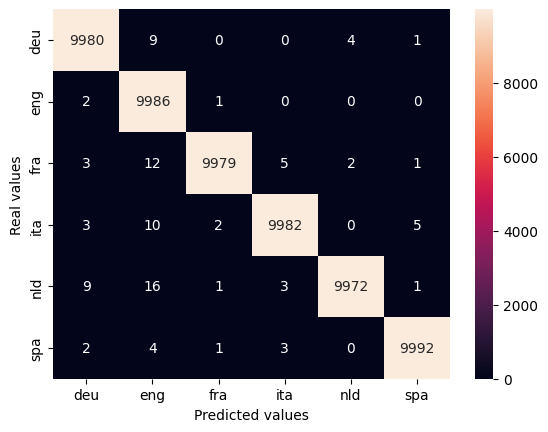

WRONG PREDICTIONS:
*True: deu, Predicted: eng, Text: " all das hat otto normal patient nicht."
*True: deu, Predicted: nld, Text: " b. angioödem, stevensjohnsonsyndrom, toxische epidermale nekrolyse) gegen lenalidomid gezeigt haben."
*True: deu, Predicted: eng, Text: " blick musiker marc r. († )."
*True: deu, Predicted: eng, Text: " call of duty: black ops (bild: activision) call of duty: black ops spielt in düsterer zukunft call of duty: black ops (bild: activision) im quellcode der offiziellen seite hat activision ein paar informationen über black ops untergebracht."
*True: deu, Predicted: eng, Text: " darunter das restaurant mappamondo und der takeawaybetrieb the beef burger."
*True: deu, Predicted: nld, Text: " der stoffbeutel war leer."
*True: deu, Predicted: eng, Text: " dieses mal mit mission impossible rogue nation, fantastic four oder ruth alex, u.v.m.. außerdem im heft: interviews mit rebecca ferguson, paul rudd sowie legolas gimli."
*True: deu, Predicted: spa, Text: " foto: s

In [73]:
# Test
prediction_errors_list = []
predictions = {language: [] for language in test.keys()}

for language in test.keys():
	for sentence in test[language]:
		probs = []
		for lingua in trigrams.keys():
			prob = probs_total(sentence, lingua, linear_discounting)
			probs.append((lingua, prob))
		max_prob = max(probs, key = lambda x: x[1])
		predictions[language].append(max_prob[0])
		if max_prob[0] != language:
			prediction_errors_list.append({"text": sentence, "true": language, "pred": max_prob[0]})

# Calculate accuracy
correct_predictions = {language: sum([1 for pred in predictions[language] if pred == language]) for language in test.keys()}
total_accuracy = sum(correct_predictions.values()) / sum([len(value) for value in test.values()])

# Print results
print(f"Total errors: {len(prediction_errors_list)} out of {sum([len(value) for value in test.values()])} sentences.")
print(f"Total accuracy: {total_accuracy}")
for language, correct in correct_predictions.items():
	print(f"*Accuracy {language}: {correct / len(test[language])}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

language_names = [language for language in test.keys()]

cm = confusion_matrix(y_true=[language for language in test.keys() for _ in range(len(test[language]))],
					  y_pred=[pred for language in test.keys() for pred in predictions[language]],
					  labels=language_names)

sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=language_names, yticklabels=language_names)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

# Print the errors
print("WRONG PREDICTIONS:")
for error in prediction_errors_list:
	print(f"*True: {error['true']}, Predicted: {error['pred']}, Text: \"{error['text']}\"")